In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import IntegerType, DoubleType, BooleanType, StringType, TimestampType
spark = SparkSession.Builder().appName('DDAM_Project_South').getOrCreate()
sqlCtx = SQLContext(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/02 14:06:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/02 14:06:32 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
from pyspark.ml.feature import VectorAssembler, StandardScaler


In [3]:
df=spark.read.csv("../../Datasets/South_Incidents_Cleaned.csv", header=True, inferSchema=True, sep=",")

In [ ]:
df=df.distinct()

In [5]:
df=df.drop('Pressure_in')

In [6]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
missing.toPandas().T

23/12/02 14:07:41 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,0
Severity,0
Start_Time,0
Start_Lat,0
Start_Lng,0
Distance_mi,0
City,0
County,0
State,0
Temperature_F,0
Wind_Chill_F,0


CORRELAZIONE

In [8]:
numerical_features=['Distance_mi', 'Temperature_F', 'Wind_Chill_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']

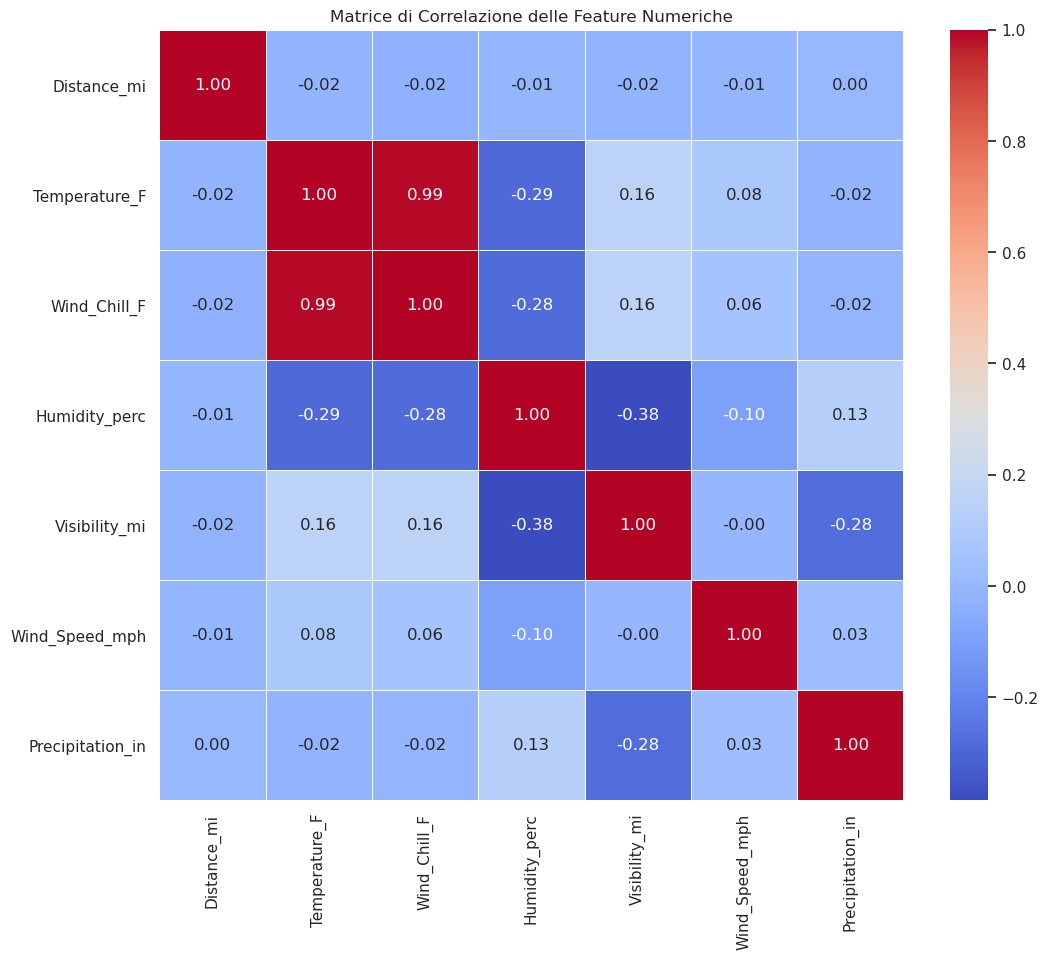

In [9]:
numerical_features=['Distance_mi', 'Temperature_F', 'Wind_Chill_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
df_numerical = df.select(numerical_features)
df_numerical_pd = df_numerical.toPandas()
matrice_correlazione = df_numerical_pd.corr()
plt.figure(figsize=(12, 10))
sns.set(font_scale=1)
sns.heatmap(matrice_correlazione, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Matrice di Correlazione delle Feature Numeriche")
plt.show()

In [10]:
df=df.drop('Wind_Chill_F')

OUTLIER DETECTION

In [11]:
cols=['Distance_mi', 'Temperature_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']

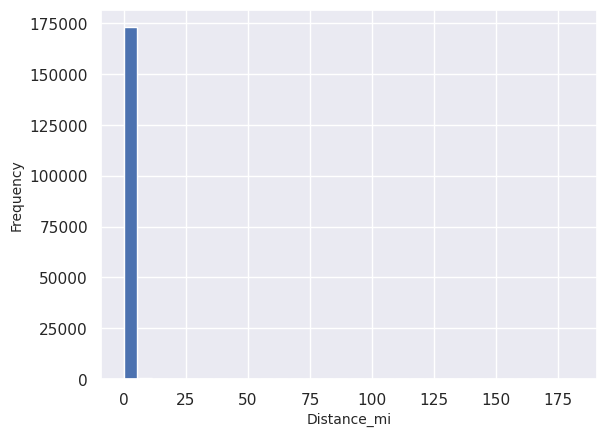

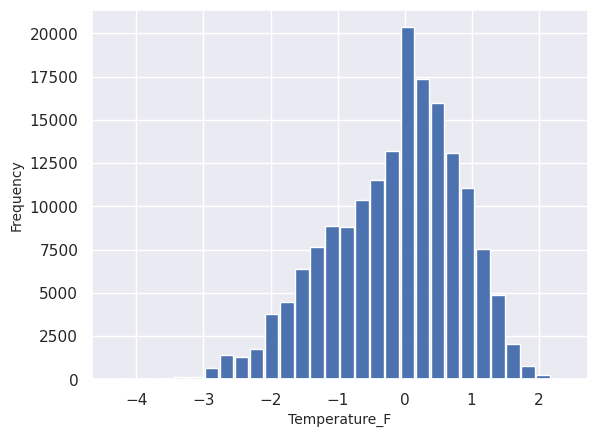

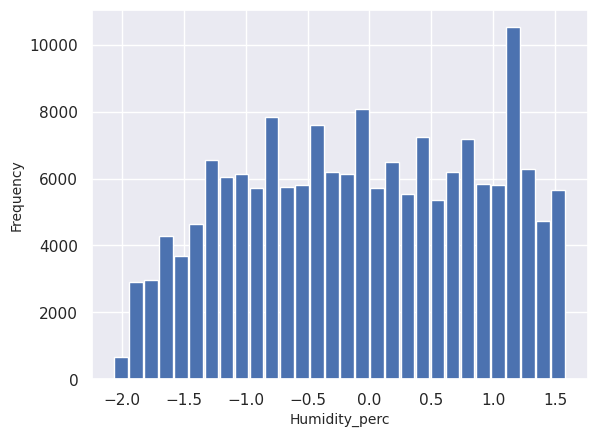

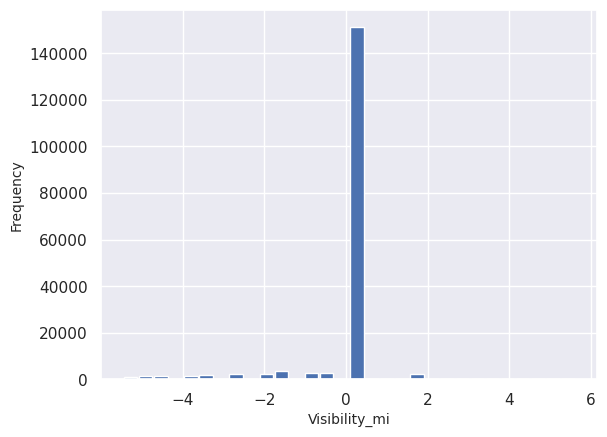

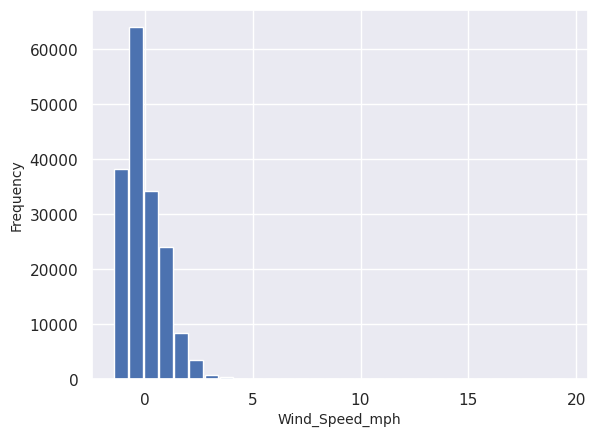

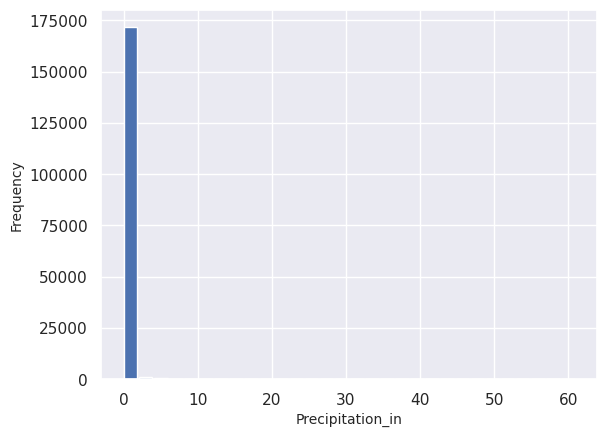

In [18]:
assembler = VectorAssembler(inputCols=cols, outputCol="features")
assembled_df = assembler.transform(df)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
# Calcola la media e la deviazione standard
scaler_model = scaler.fit(assembled_df)
# Applica lo StandardScaler al DataFrame
scaled_df = scaler_model.transform(assembled_df)
scaled_df.createOrReplaceTempView("Incidents_Data")
query = spark.sql('SELECT scaled_features FROM Incidents_Data') 
i=0
for col in cols:
    h = query.select('scaled_features').rdd.map(lambda x: x[0][i]).histogram(30)
    dfh = pd.DataFrame(
        list(zip(*h)), 
        columns=['bin', 'frequency']
    )
    # estraggo dai dal dataframe pandas per ottenere i bin e le frequenze necessari per il plotting
    bins = dfh['bin']
    counts = dfh['frequency']
    #  classic pandas syntax
    plt.hist(bins, len(bins), weights=counts, rwidth=0.9)
    plt.xlabel(f'{col}', size=10)
    plt.ylabel("Frequency", size=10)
    #plt.grid(True) 
    plt.show()
    i+=1

In [20]:
scaled_df

DataFrame[Severity: int, Start_Time: timestamp, Distance_mi: double, City: string, County: string, State: string, Temperature_F: double, Humidity_perc: double, Pressure_in: double, Visibility_mi: double, Wind_Direction: string, Wind_Speed_mph: double, Precipitation_in: double, Weather_Condition: string, Amenity: boolean, Bump: boolean, Crossing: boolean, Give_Way: boolean, Junction: boolean, No_Exit: boolean, Railway: boolean, Roundabout: boolean, Station: boolean, Stop: boolean, Traffic_Calming: boolean, Traffic_Signal: boolean, Turning_Loop: boolean, Astronomical_Twilight: string, month: int, hour: int, season: string, features: vector, scaled_features: vector]

In [22]:
scaled_df.createOrReplaceTempView("outliers") 
query = sqlCtx.sql("Select scaled_features from outliers o")
#query.show()
i=0
xy_columns = ['Distance_mi', 'Temperature_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
range_=[(-2,5),(-3,2),(-3,2),(-5,2),(-2,4),(-1,4)]
i=0
for col in xy_columns: 
    h = query.select('scaled_features').rdd.map(lambda x: x[0][i])
    even_numbers = h.filter(lambda x: x>range_[i][1] or x<range_[i][0])
    print(even_numbers.count(),'è la colonna',col)
    i+=1

671 è la colonna Distance_mi


1106 è la colonna Temperature_F


0 è la colonna Humidity_perc


1196 è la colonna Visibility_mi


227 è la colonna Wind_Speed_mph


990 è la colonna Precipitation_in


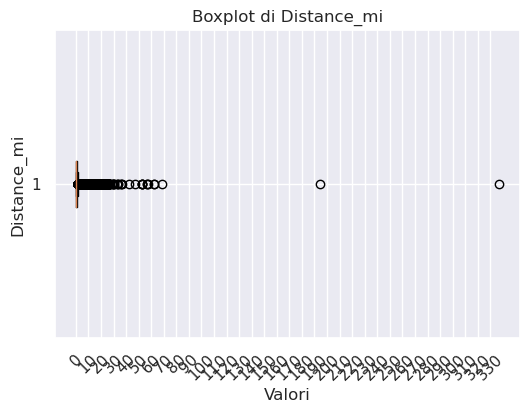

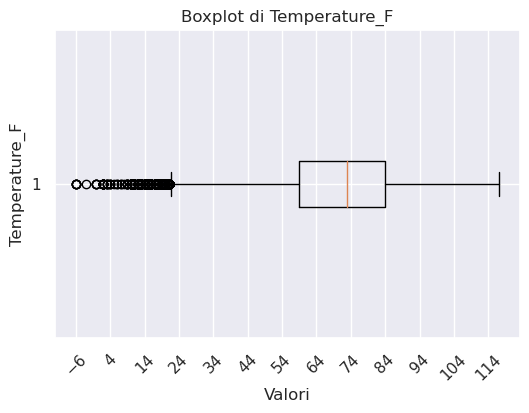

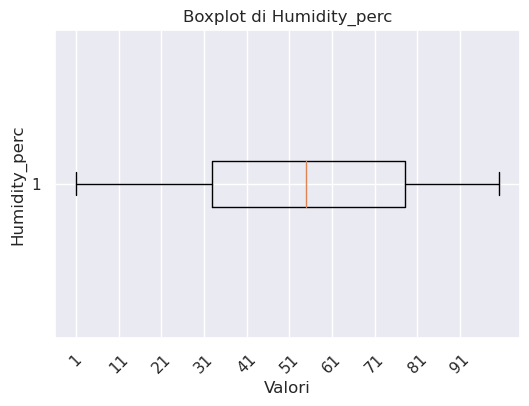

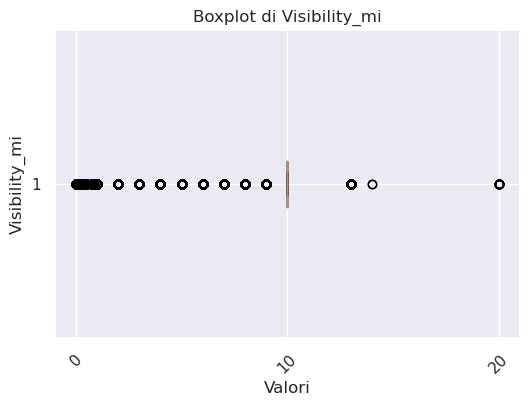

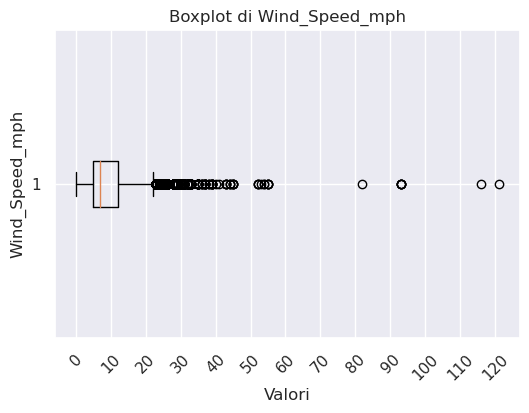

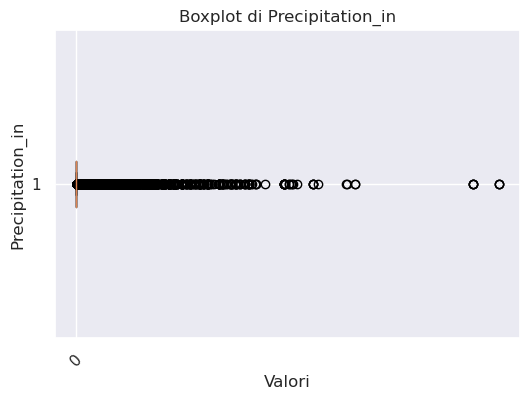

[['Numero outlier per Distance_mi 18744'], ['Numero outlier per Temperature_F 969'], ['Numero outlier per Humidity_perc 0'], ['Numero outlier per Visibility_mi 22294'], ['Numero outlier per Wind_Speed_mph 2287'], ['Numero outlier per Precipitation_in 7673']]


In [23]:
df.createOrReplaceTempView("df")
outliers_list=[]
for col in cols: 
    df_filtered = df.filter(df[col].isNotNull())
    percentiles = df_filtered.approxQuantile(col, [0.25, 0.5, 0.75], 0.01)
    Q1, median, Q3 = percentiles
    IQR=Q3-Q1
    W1=Q1-1.5*IQR
    W3=Q3+1.5*IQR
    query=""" SELECT """+ col + """ FROM df WHERE """ + col + """<""" + str(W1) +""" OR """+ col + """>""" + str(W3)
    outliers=sqlCtx.sql(query)
    numero_outliers=outliers.count()
    outliers_list.append(['Numero outlier per '+ col+' '+str(numero_outliers)])
    min_Query=""" SELECT MIN("""+col+""") AS Min FROM df """
    min_=sqlCtx.sql(min_Query)
    min_=min_.select('Min').rdd.flatMap(lambda x: x).collect()[0]
    max_Query=""" SELECT MAX("""+col+""") AS Max FROM df """
    max_=sqlCtx.sql(max_Query)
    max_=max_.select('Max').rdd.flatMap(lambda x: x).collect()[0]
    plt.figure(figsize=(6, 4))
    plt.boxplot([df_filtered.select(col).rdd.flatMap(lambda x: x).collect()], vert=False)
    plt.title('Boxplot di {}'.format(col))
    plt.xlabel('Valori')
    plt.ylabel('{}'.format(col))
    #plt.xticks([W1, Q1, median, Q3,W3], ['W1', 'Q1', 'Median', 'Q3', 'W3'])
    plt.xticks(range(int(min_),int(max_)+1,10), rotation=45)
    plt.show()
print(outliers_list)